![](2022-11-18-21-14-47.png)

# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore")
# warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns = ['Sales']

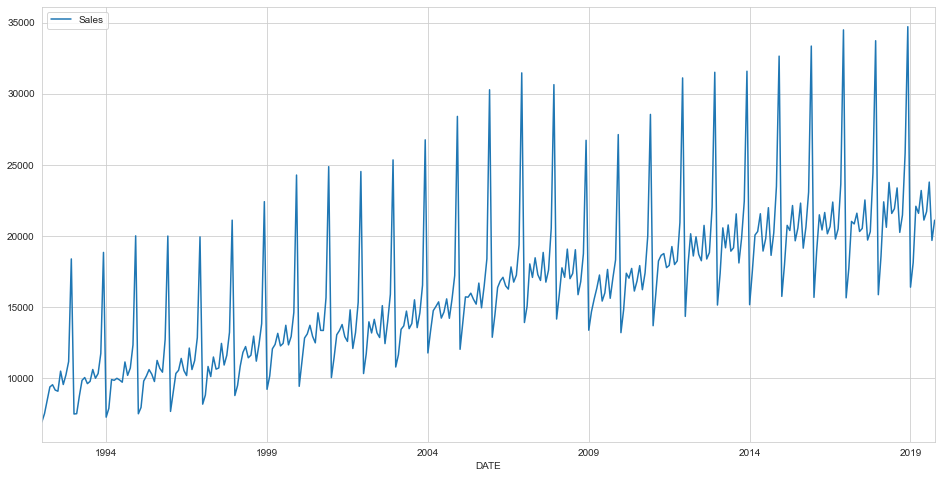

In [7]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

In [8]:
len(df)

334

In [9]:
test_size = 24

In [10]:
test_index = len(df) - test_size
test_index

310

In [11]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [13]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [19]:
length = 12    # Get 12 value and will predict 13. value.
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)   # shuffle = false

In [20]:
len(generator) # (310-12) / (1*1)

298

In [21]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}') # Flatten is only visulization
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
train_scaled.shape

(310, 1)

In [26]:
n_features = train_scaled.shape[1]
n_features

1

In [27]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))  # return_sequences is important when we have at least 2 LSTM.
model.add(LSTM(50, activation = 'relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2)) # Last output dense and second LSTM parameters didin't added.

40800

In [30]:
4 * ((100+1)*50+(50**2))

30200

### EarlyStopping and Validation Generator

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [33]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [34]:
len(validation_generator)

12

In [35]:
model.fit(generator,
        epochs = 20,
        validation_data = validation_generator,
        callbacks = [early_stop])

Epoch 1/20


C:\Users\EmincanY\AppData\Local\Temp\ipykernel_7496\436712031.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,


298/298 [==============================] - 5s 9ms/step - loss: 0.0225 - val_loss: 0.0229
Epoch 2/20
298/298 [==============================] - 2s 8ms/step - loss: 0.0183 - val_loss: 0.0162
Epoch 3/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0116 - val_loss: 0.0076
Epoch 4/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 5/20
298/298 [==============================] - 3s 9ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 6/20
298/298 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 8/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 9/20
298/298 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 9.3746e-04
Epoch 10/20
298/298 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 8.2839e-04
Ep

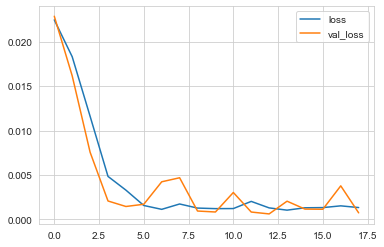

In [36]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

## Evaluate on Test Data

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [39]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

1/1 [==============================] - 0s 53ms/step


In [40]:
current_pred

array([[0.49493498]], dtype=float32)

In [41]:
current_batch

array([[[0.6157732 ],
        [0.98862702],
        [0.35240644],
        [0.41583881],
        [0.51526922],
        [0.51068163],
        [0.53588796],
        [0.49411941],
        [0.50010508],
        [0.5699476 ],
        [0.47734097],
        [0.49493498]]])

In [42]:
predictions_scaled

[array([0.6157732], dtype=float32),
 array([0.988627], dtype=float32),
 array([0.35240644], dtype=float32),
 array([0.4158388], dtype=float32),
 array([0.5152692], dtype=float32),
 array([0.5106816], dtype=float32),
 array([0.53588796], dtype=float32),
 array([0.4941194], dtype=float32),
 array([0.5001051], dtype=float32),
 array([0.5699476], dtype=float32),
 array([0.47734097], dtype=float32),
 array([0.49493498], dtype=float32)]

In [43]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.9450065319671676 
mae: 0.029467764778409133 
mse: 0.0012179637331550038 
rmse: 0.03489933714492302


### Inverse Transformations and Comparing

In [44]:
predictions = scaler.inverse_transform(predictions_scaled)

In [45]:
compare = test[:12]

In [46]:
compare['Predictions'] = predictions

C:\Users\EmincanY\AppData\Local\Temp\ipykernel_7496\4075765098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare['Predictions'] = predictions


In [47]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,23898.857
2017-12-01,33720,34168.743
2018-01-01,15881,16644.683
2018-02-01,18585,18391.864
2018-03-01,22404,21130.575
2018-04-01,20616,21004.215
2018-05-01,23764,21698.498
2018-06-01,21589,20548.025
2018-07-01,21919,20712.894


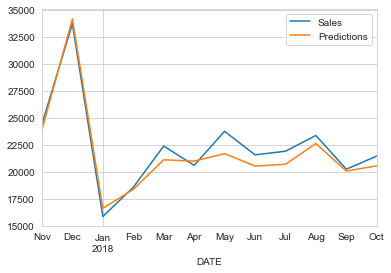

In [48]:
compare.plot();

In [49]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.9450065319671673 
mae: 811.6601130565028 
mse: 924034.9034104976 
rmse: 961.2673423197615


## Retrain and Forecasting

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [51]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [52]:
len(df)

334

In [53]:
len(generator)

322

In [54]:
model = Sequential()

model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs = 15)

Epoch 1/15


C:\Users\EmincanY\AppData\Local\Temp\ipykernel_7496\1908341200.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 15)


322/322 [==============================] - 6s 8ms/step - loss: 0.0275
Epoch 2/15
322/322 [==============================] - 2s 8ms/step - loss: 0.0159
Epoch 3/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0084
Epoch 4/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0043
Epoch 5/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0024
Epoch 6/15
322/322 [==============================] - 2s 8ms/step - loss: 0.0020
Epoch 7/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0016
Epoch 8/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 9/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 10/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 11/15
322/322 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 12/15
322/322 [==============================] - 2s 8ms/step - loss: 9.7460e-04
Epoch 13/15
322/322 [===========

In [55]:
scaled_full_data.shape

(334, 1)

In [56]:
scaled_full_data[-length:].shape

(12, 1)

In [57]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

1/1 [==============================] - 0s 28ms/step


In [58]:
forecast = scaler.inverse_transform(forecast)

In [59]:
forecast

array([[26841.00334787],
       [36671.41197968],
       [17568.8497541 ],
       [19085.78437877],
       [22694.40661526],
       [22220.66806364],
       [23883.60190392],
       [21812.45997667],
       [22396.83115816],
       [24522.4841218 ],
       [20591.11839557],
       [21978.73316717]])

In [60]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [61]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

In [62]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [63]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [64]:
forecast_df

,Forecast
2019-11-01,26841.003
2019-12-01,36671.412
2020-01-01,17568.850
2020-02-01,19085.784
2020-03-01,22694.407
2020-04-01,22220.668
2020-05-01,23883.602
2020-06-01,21812.460
2020-07-01,22396.831
2020-08-01,24522.484


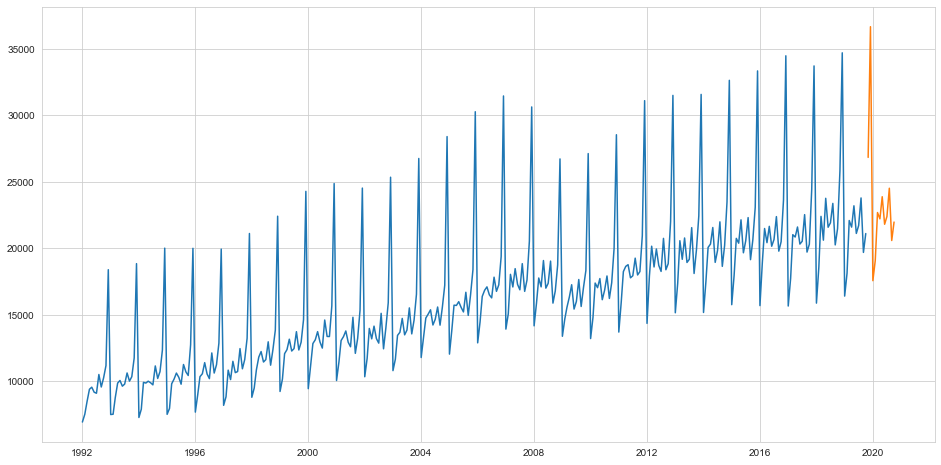

In [66]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast']);

In [ ]:
# Done !